## Import Packages

In [1]:
import os
import gc
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import nltk
from nltk.tokenize import TweetTokenizer, PunktSentenceTokenizer
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')

from time import time 
from functools import partial
from tqdm.notebook import tqdm
from pprint import pprint

from transformers import AutoTokenizer, AutoModel
from datasets import Dataset as HF_Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, cohen_kappa_score

from scipy.special import softmax

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)

PyTorch Version: 2.2.1
CUDA Available: True
CUDA Version: 11.8


In [2]:
# Global Var

platform = '.' # '/kaggle' or '.'

TRAIN_CSV = f'{platform}/input/learning-agency-lab-automated-essay-scoring-2/train.csv'
MODEL_DIR = f'{platform}/input/huggingfacedebertav3variants'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

Using device: cuda


In [3]:
class TRAIN_CONFIG:
    MODEL_NAME="DeBerta_RNN"
    OUTPUT_DIR=f"{platform}/working"
    N_SPLITS=5
    MAX_LENGTH=512
    EMBEDDING_SIZE = 768
    DEBERTA_PATH = f"{MODEL_DIR}/deberta-v3-small"
    USE_SCORE_WEIGHTS = np.array([1, 5, 6, 5, 0.75, 0.25])
    BATCH_SIZE = 8
    EPOCHS = 5
    MAX_LR = 1e-5
    LR_FINAL_DIV= 1000
    PRINT_EPOCH_FREQ = 1
    NUM_WORKERS = 0
    AMP = True
    GRADIENT_ACCUMULATION_STEPS = 1
    PRINT_FREQ = None
    WEIGHT_DECAY = 0.02
    MAX_GRAD_NORM = 1e7
    SEED = 2046

In [4]:
def seed_everything(seed):

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

# fix random seed
seed_everything(seed=TRAIN_CONFIG.SEED)

# Load Data

Load CSV, convert to tokens, and generate embedding.

In [5]:
train_csv = pd.read_csv(TRAIN_CSV, nrows=None)
train_csv['label'] = train_csv['score'] - 1
train_csv['text_length'] = train_csv['full_text'].apply(lambda x: len(x.split()))

print("train_csv shape = ", train_csv.shape)

train_csv.sort_values('text_length', ascending=False).head()

train_csv shape =  (17307, 5)


,essay_id,full_text,score,label,text_length
2155,20cb752,I thought it might be boring and a lot of work...,2,1,1656
8609,7fe2d12,"To the state and the state's country, the elec...",6,5,1367
15824,e9831f4,When limiting car usage the first thing that m...,6,5,1351
2803,29daf40,As the global concern for the environment incr...,5,4,1312
5158,4d00492,"Dear Senator,\n\nConcerning the topic of the m...",6,5,1302


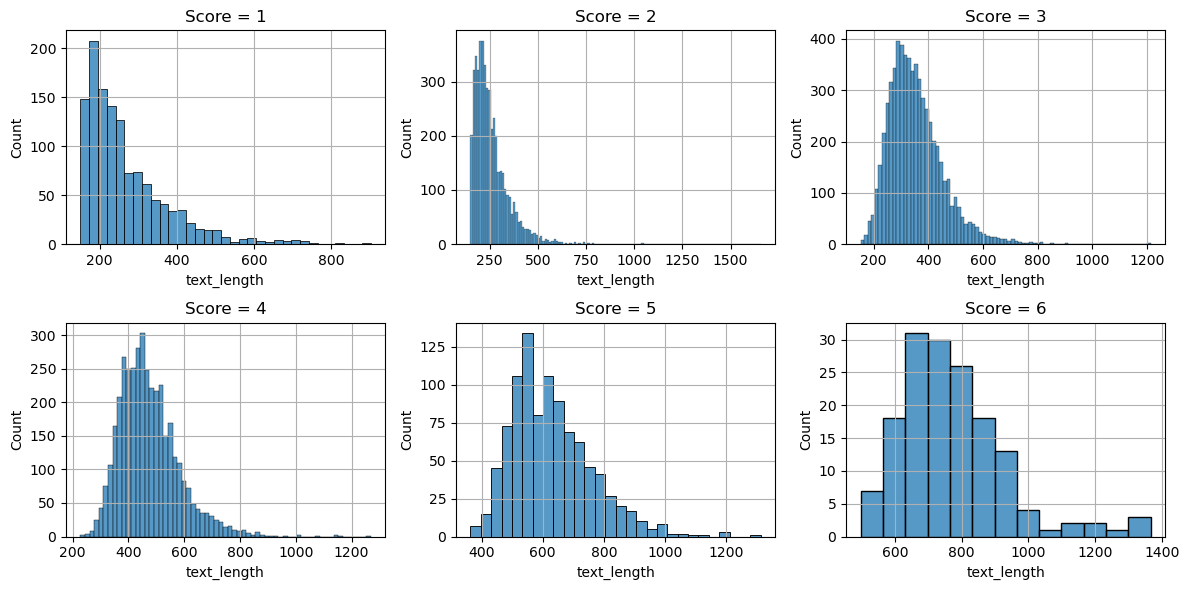

In [6]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    sns.histplot(train_csv[train_csv['score']==i+1]['text_length'], ax=ax, kde=False)
    ax.set_title(f"Score = {i+1}")
    ax.grid(True)
    
plt.tight_layout()
plt.show()

In [7]:
def remove_extra_whitespace_tabs(text):
    cleaned_text =  re.sub(r'(\s*[?]+|\xa0)\s*', ' ', text)
    cleaned_text = re.sub(r'^\s*|\s\s*', ' ', cleaned_text).strip()
    return cleaned_text

def tokenize_and_chunk(df, max_length=512):
    # Initialize the tokenizers
    results = {
        'essay_id': [],
        'label': [],
        'segment_text': [],
    }
    
    sent_tokenizer = PunktSentenceTokenizer()

    for i, row in tqdm(df.iterrows(), desc='Chunking', total=len(df)):
        text = remove_extra_whitespace_tabs(row['full_text'])
        if row['text_length'] <= max_length:
            results['essay_id'].append(row['essay_id'])
            results['label'].append(row['label'])
            results['segment_text'].append(text)
            
        else:
            sentences = sent_tokenizer.tokenize(text)
            num_chunks = np.ceil(row['text_length'] / max_length).astype(int)
            chunk_size = len(sentences) // num_chunks
            
            chunks = []
            for j in range(num_chunks):
                start_index = j * chunk_size
                if j == num_chunks - 1:  # Last chunk takes the remainder
                    end_index = len(sentences)
                else:
                    end_index = start_index + chunk_size
                chunks.append(' '.join(sentences[start_index:end_index]))
            
            results['essay_id'].extend([row['essay_id']] * num_chunks)
            results['label'].extend([row['label']] * num_chunks)
            results['segment_text'].extend(chunks)
            
    return results

In [8]:
results = tokenize_and_chunk(train_csv, max_length=TRAIN_CONFIG.MAX_LENGTH)

df_results = pd.DataFrame(results)

df_results['n_tokens'] = df_results['segment_text'].apply(lambda x: len(x.split()))

df_results = df_results[df_results['n_tokens'] > 0]

df_results.sort_values('n_tokens', ascending=False).head()

# It is possible to drop samples with n_tokens<150 | n_tokens>512 

Chunking:   0%|          | 0/17307 [00:00<?, ?it/s]

,essay_id,label,segment_text,n_tokens
5331,4456d26,1,Cars have been by all means the number one way...,1047
7578,6196d6e,0,the presidental election is to find a new lead...,715
11855,9715113,4,So instead of one region getting the candidate...,628
10219,827c372,3,"""All of our development since World War II has...",610
12916,a4711ba,0,etc. now like i said in the first paragraph th...,597


In [9]:
def tokenize_function(examples, tokenizer, max_length):
    
    tokenizer_kwargs = dict(
        padding='max_length', 
        truncation=True, 
        max_length=max_length,
        return_tensors = 'np',
        return_token_type_ids = False,
        return_attention_mask = True,
        return_length=False
    )
    
    tokens = tokenizer(examples['full_text'], **tokenizer_kwargs)
    
    return tokens


def collate_fn(batch):
    
    input_ids = [np.array(x['input_ids']) for x in batch]
    attention_mask = [np.array(x['attention_mask']) for x in batch]
    
    labels = torch.stack([torch.eye(6)[x['label']] for x in batch])
    
    data_dict = {
        'input_ids': torch.tensor(np.vstack(input_ids), dtype=torch.int32),
        'attention_mask': torch.tensor(np.vstack(attention_mask), dtype=torch.int8),
        'label': labels
        }
    
    return data_dict

In [10]:
embedding_tokenizer = AutoTokenizer.from_pretrained(TRAIN_CONFIG.DEBERTA_PATH, use_fast=False) 
embedding_model = AutoModel.from_pretrained(TRAIN_CONFIG.DEBERTA_PATH)

In [11]:
tokenize_fn = partial(
    tokenize_function, 
    tokenizer=embedding_tokenizer, 
    max_length=TRAIN_CONFIG.MAX_LENGTH
    )

train_ds = HF_Dataset.from_dict({
    'essay_id': df_results['essay_id'].to_list(),
    'full_text': df_results['segment_text'].to_list(),
    'label': df_results['label'].to_list()
    })

train_ds = train_ds.map(tokenize_fn, batched=True)

Map:   0%|          | 0/20024 [00:00<?, ? examples/s]

In [12]:
pprint(train_ds['full_text'][1980])

('Would a computer that can read you emotions be good for the class room '
 'Facial Action Coding System allows technology to identify human emotions. '
 'Therefore it can tell weather someone is happy or sad. The machine can also '
 'tell if you are feeling mixed emotions by the muscle movement in your face. '
 '"\'A classroom computer could recognize when a student is becoming confused '
 "or bored,' Dr. Huang ptrdicts. 'then it could modify the lesson, like an "
 'efffective human instructor" (paragraph 6 "making mona lisa smile"). If the '
 'FACS systems was downloaded into the computers at school then students would '
 'learn better because the computer would know the best way to teach them '
 'based on there emotions. Second "\'most human communication is nonverbal, '
 "including emotional communication,' notes Dr. huang. 'so computers need to "
 'understand that, too."(paragraph 6 "making mona lisa smile"). Since people '
 "can't always tell the emotions of another person in the

In [ ]:
## Test dataloader

# data_loader = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)
# for batch in data_loader:
#     data_dict = batch
    
#     print(data_dict['input_ids'].shape)
#     print(data_dict['attention_mask'].shape)
#     print(data_dict['label'].shape)
    
#     with torch.no_grad():
#         embeddings = embedding_model(
#             input_ids = data_dict['input_ids'],
#             attention_mask = data_dict['attention_mask']
#         )['last_hidden_state']
        
#     print(embeddings.shape)
    
#     break

# Model

In [13]:
# GRU model
class SelfAttentionPooling(nn.Module):
    """
    Implementation of SelfAttentionPooling
    Original Paper: Self-Attention Encoding and Pooling for Speaker Recognition
    https://arxiv.org/pdf/2008.01077v1.pdf
    """
    def __init__(self, input_dim):
        super(SelfAttentionPooling, self).__init__()
        self.W = nn.Linear(input_dim, 1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, batch_rep, attention_mask):
        """
        input:
            batch_rep : size (N, T, H), N: batch size, T: sequence length, H: Hidden dimension
        return:
            utter_rep: size (N, H)
        """
        att_logits = self.W(batch_rep).squeeze(-1)
        att_logits.masked_fill_((attention_mask==0).squeeze(-1), float('-inf'))
        att_w = self.softmax(att_logits).unsqueeze(-1)
        utter_rep = torch.sum(batch_rep * att_w, dim=1)
        return utter_rep

class DeBERTaGRUClassifier(nn.Module):
    
    def __init__(self, embedding_model, embedding_dim, hidden_size, n_classes):
        super(DeBERTaGRUClassifier, self).__init__()
        
        self.berta = AutoModel.from_pretrained(embedding_model)
        self.attention_pooling = SelfAttentionPooling(hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, hidden_size//2),
            nn.SiLU(),
            nn.Linear(hidden_size//2, n_classes)
        )
        
    def forward(self, input_ids, attention_mask):
        
        # get embeddings from berta
        embeddings = self.berta(
            input_ids = input_ids,
            attention_mask = attention_mask
        )['last_hidden_state']
        
        # pass attention_pooling
        hidden_state = self.attention_pooling(embeddings, attention_mask)
        logits = self.mlp(hidden_state)
        
        output = {
            'logits': logits,
            'hidden_state': hidden_state
        }
        
        return output

In [14]:
# Test Model

model = DeBERTaGRUClassifier(
        TRAIN_CONFIG.DEBERTA_PATH, 
        embedding_dim=TRAIN_CONFIG.EMBEDDING_SIZE, 
        hidden_size=768, 
        n_classes=6
    )

data_loader = DataLoader(train_ds, batch_size=16, collate_fn=collate_fn)

# model.to(DEVICE)
for data_dict in data_loader:
    input_ids = data_dict['input_ids']#.to(DEVICE)
    attention_mask = data_dict['attention_mask']#.to(DEVICE)
    model_output = model(input_ids, attention_mask)
    print("Model output logits shape: ", model_output['logits'].shape)
    print("Model output hidden_state shape: ", model_output['hidden_state'].shape)
    
    input_ids.detach().cpu() 
    attention_mask.detach().cpu()
    del input_ids, attention_mask
    gc.collect()
    torch.cuda.empty_cache()
    
    break

Model output logits shape:  torch.Size([16, 6])
Model output hidden_state shape:  torch.Size([16, 768])


# Model Training

### Define Loss

In [15]:
from typing import Optional

class OrdinalCrossEntropyLoss(nn.Module):
    def __init__(self, n_class, weights=None, a=2, epsilon=1e-13, device='cpu'):
        super(OrdinalCrossEntropyLoss, self).__init__()
        self.a = a
        self.epsilon = epsilon
        self.device = device

        d_matrix = (torch.arange(n_class, device=device).unsqueeze(0) - 
                    torch.arange(n_class, device=device).unsqueeze(1)).abs()
        
        if weights is not None:
            w_matrix = (torch.tensor(weights, device=device).unsqueeze(0) +
                        torch.tensor(weights, device=device).unsqueeze(1)).float()
            c_matrix = (d_matrix.float().pow(a) + 1) * w_matrix
        else:
            c_matrix = d_matrix.float().pow(a)
        
        self.register_buffer('C', c_matrix)
        
    def forward(self, y_pred, y_true):
        # select corresponding rows from D
        distances = torch.matmul(y_true.float(), self.C)
        probas = torch.softmax(y_pred, dim=1)
        loss = -torch.sum(torch.log(self.epsilon + 1 - probas) * distances , dim=1)
        
        return loss.mean()


class CohenKappa:
    def __init__(self, weights='quadratic'):
        self.weights = weights

    def __call__(self, y_pred, y_true):
        """
        Calculate Cohen's Kappa score.
        :param y_pred: logits or probability -> [B, n_class].
        :param y_true: one-hot code of true labels  -> [B, n_class].
        :return: kappa score.
        """
        y_pred_classes = torch.argmax(y_pred, dim=1)
        y_true_classes = torch.argmax(y_true, dim=1)
        kappa = cohen_kappa_score(
            y_true_classes.cpu().numpy(), 
            y_pred_classes.cpu().numpy(), 
            weights=self.weights
            )
        
        return kappa

In [16]:
# # test loss functions
# n_sample = 16
# n_class = 6
# identity_matrix = torch.eye(n_class)

# y_true = torch.randint(0, n_class, size=(n_sample, 1))
# y_true = torch.matmul(identity_matrix[y_true.squeeze()], identity_matrix)

# loss_fn = OrdinalCrossEntropyLoss(n_class=6, weights=TRAIN_CONFIG.USE_SCORE_WEIGHTS)
# kappa_fn = CohenKappa(weights='quadratic')

# print("Test Loss Functions: ")
# for i in range(3):
#     y_logits = torch.randn(n_sample, n_class) 
#     ordinal_ce = loss_fn(y_logits, y_true).numpy()
#     kappa_coeff = kappa_fn(torch.softmax(y_logits, dim=1), y_true)
#     print(f"{i}: Ordinal CE Loss = {ordinal_ce:.6f}, Kappa = {kappa_coeff:.6f}", )

### Train Functions

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class Trainer:

    def __init__(self, model, loss_fn, evel_fn, config):

        self.model = model
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn
        self.loss_fn.to(self.device)
        
        self.eval_fn = evel_fn
        
    def train(self, train_loader, valid_loader, print_epoch_freq=50, from_checkpoint=None):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.WEIGHT_DECAY)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.MAX_LR,
            epochs=self.config.EPOCHS,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.LR_FINAL_DIV,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf")
        loss_records = {"train": [], "valid": []}
        
        pbar = tqdm(range(self.config.EPOCHS), total=self.config.EPOCHS, unit="epoch", leave=True, desc="Training Progress")
        for epoch in pbar:
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False)

            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == (self.config.EPOCHS - 1)):
                pbar.set_postfix(
                    epoch=epoch + 1, 
                    loss=f"{train_loss:.4f} | {valid_loss:.4f}", 
                    time=f"{elapsed:.2f}s"
                    )
                
            # if valid_loss < best_loss:
            if valid_loss > best_loss:
                best_loss = valid_loss
                best_weights = self.model.state_dict()
                best_preds = valid_preds
                print(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")
             
        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.AMP)
        loss_meter, predicts_record = AverageMeter(), []

        start = time()
        for step, data_dict in tqdm(enumerate(dataloader), total=len(dataloader), desc=mode, unit="batch"):
            
            input_ids = data_dict['input_ids'].to(DEVICE)
            attention_mask = data_dict['attention_mask'].to(DEVICE)
            labels = data_dict['label'].to(DEVICE)
            
            if is_train:
                with autocast(enabled=self.config.AMP):
                    model_output = self.model(input_ids, attention_mask)
                    logits = model_output['logits']
                    loss = self.loss_fn(logits, labels)
                    
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                    
                scaler.scale(loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.MAX_GRAD_NORM)
                if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
            else:
                with torch.no_grad():
                    model_output = self.model(input_ids, attention_mask)
                    logits = model_output['logits']
                    # loss = self.loss_fn(logits, labels)
                    loss = self.eval_fn(F.softmax(logits, dim=1), labels)
                    
                if self.config.GRADIENT_ACCUMULATION_STEPS > 1:
                    loss = loss / self.config.GRADIENT_ACCUMULATION_STEPS
                
                predicts_record.append(logits.to('cpu').numpy())
            
            loss_meter.update(loss.item(), labels.size(0))
            end = time()
            
            if self.config.PRINT_FREQ:
                if (step % self.config.PRINT_FREQ == 0) or (step == (len_loader - 1)):
                    lr = self.scheduler.get_last_lr()[0]
                    info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} Loss: {loss_meter.avg:.4f}"
                    if is_train:
                        info += f" Grad: {grad_norm:.4f} LR: {lr:.4e}"
                    info += f" | Elapse: {end - start:.2f}s"
                    print(info)

        if not is_train:
            predicts_record = np.concatenate(predicts_record)

        return loss_meter.avg, predicts_record

    
def train_fold(fold_id, model, loss_fn, evel_fn, train_folds, valid_folds, config):

#     train_dataset = TextDataset(train_folds, n_class=6, mode="train")
#     valid_dataset = TextDataset(valid_folds, n_class=6, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": config.BATCH_SIZE,
        "num_workers": config.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
        'collate_fn': collate_fn
    }
    print(loader_kwargs)
    print(" ")

    train_loader = DataLoader(train_folds, drop_last=True,  **loader_kwargs)
    valid_loader = DataLoader(valid_folds, drop_last=False, **loader_kwargs)

    trainer = Trainer(model, loss_fn, evel_fn, config)
    best_weights, best_preds, loss_records = trainer.train( 
        train_loader, valid_loader, print_epoch_freq=config.PRINT_EPOCH_FREQ, from_checkpoint=None)

    save_model_name = f"{config.MODEL_NAME}_fold_{fold_id}.pth"
    torch.save(best_weights, os.path.join(config.OUTPUT_DIR, save_model_name))

    del train_folds, valid_folds, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

### Training Loop

In [21]:
k_folds = 5
skf = StratifiedKFold(n_splits=TRAIN_CONFIG.N_SPLITS, shuffle=False)

df_folds = pd.DataFrame({
    'example_id': range(len(train_ds)), 
    'score': train_ds['label'], 
    'fold': 0
    })

for fold, (train_idx, val_idx) in enumerate(skf.split(df_folds, df_folds['score'])):
    df_folds.loc[val_idx, 'fold'] = fold

display(df_folds['fold'].value_counts())

fold
0    4005
1    4005
2    4005
3    4005
4    4004
Name: count, dtype: int64

Fold: 0 || train_sz=16019; valid_sz=4005 
{'batch_size': 8, 'num_workers': 0, 'pin_memory': True, 'shuffle': False, 'collate_fn': <function collate_fn at 0x7f83c690e3e0>}
 


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 1: Best model found with loss = 0.5155.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 2: Best model found with loss = 0.5877.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 3: Best model found with loss = 0.6121.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 4: Best model found with loss = 0.6467.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 5: Best model found with loss = 0.6520.


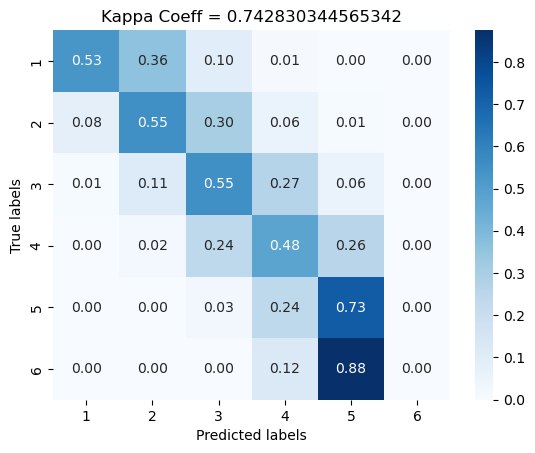

Fold 1 | Running Time: 28.98 min 
- Overall Valid Loss: 0.742830344565342
Fold: 1 || train_sz=16019; valid_sz=4005 
{'batch_size': 8, 'num_workers': 0, 'pin_memory': True, 'shuffle': False, 'collate_fn': <function collate_fn at 0x7f83c690e3e0>}
 


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 1: Best model found with loss = 0.5406.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 2: Best model found with loss = 0.5805.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 3: Best model found with loss = 0.6299.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 4: Best model found with loss = 0.6428.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 5: Best model found with loss = 0.6553.


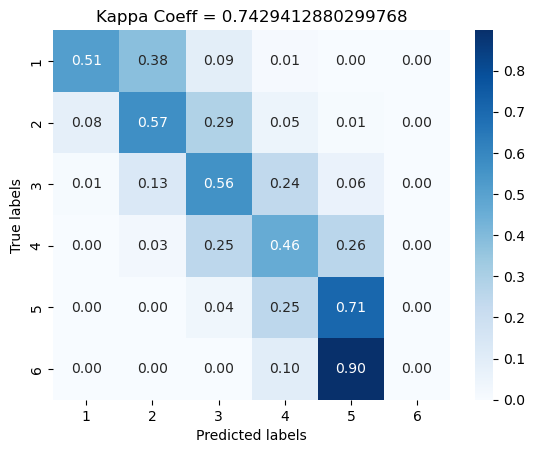

Fold 2 | Running Time: 29.03 min 
- Overall Valid Loss: 0.7429412880299768
Fold: 2 || train_sz=16019; valid_sz=4005 
{'batch_size': 8, 'num_workers': 0, 'pin_memory': True, 'shuffle': False, 'collate_fn': <function collate_fn at 0x7f83c690e3e0>}
 


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 1: Best model found with loss = 0.5711.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 2: Best model found with loss = 0.6030.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 3: Best model found with loss = 0.6416.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 4: Best model found with loss = 0.6628.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 5: Best model found with loss = 0.6708.


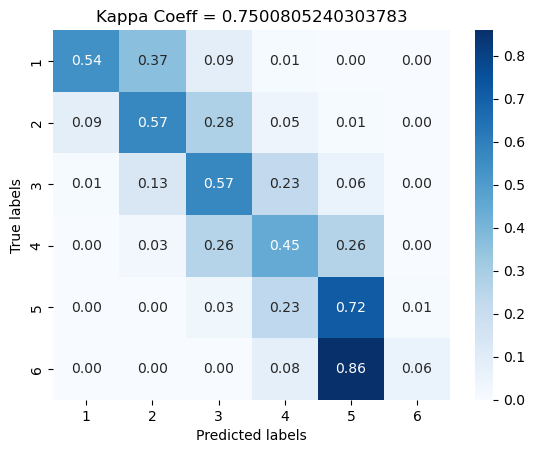

Fold 3 | Running Time: 29.07 min 
- Overall Valid Loss: 0.7500805240303783
Fold: 3 || train_sz=16019; valid_sz=4005 
{'batch_size': 8, 'num_workers': 0, 'pin_memory': True, 'shuffle': False, 'collate_fn': <function collate_fn at 0x7f83c690e3e0>}
 


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 1: Best model found with loss = 0.5379.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 2: Best model found with loss = 0.5834.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 3: Best model found with loss = 0.6036.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 4: Best model found with loss = 0.6311.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 5: Best model found with loss = 0.6458.


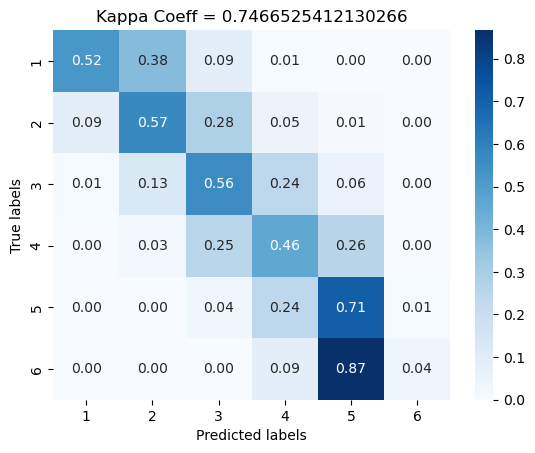

Fold 4 | Running Time: 28.97 min 
- Overall Valid Loss: 0.7466525412130266
Fold: 4 || train_sz=16019; valid_sz=4005 
{'batch_size': 8, 'num_workers': 0, 'pin_memory': True, 'shuffle': False, 'collate_fn': <function collate_fn at 0x7f83c690e3e0>}
 


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 1: Best model found with loss = 0.5292.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 2: Best model found with loss = 0.5935.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 3: Best model found with loss = 0.6220.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 4: Best model found with loss = 0.6437.


Train:   0%|          | 0/2002 [00:00<?, ?batch/s]

Valid:   0%|          | 0/501 [00:00<?, ?batch/s]

- Epoch 5: Best model found with loss = 0.6578.


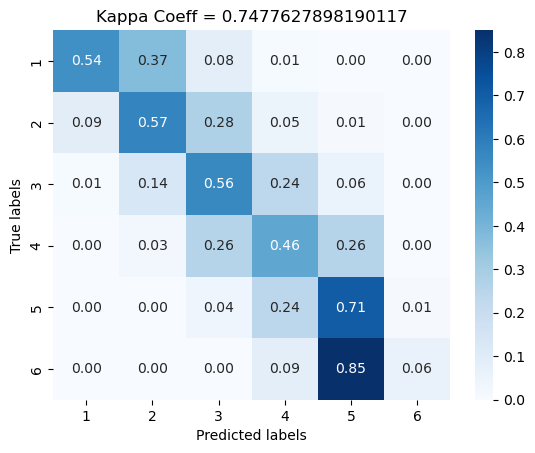

Fold 5 | Running Time: 29.04 min 
- Overall Valid Loss: 0.7477627898190117


In [22]:
# ================== Run Training ==================

target_cols = [f"score_{i}" for i in range(6)]
predict_cols = [f"predict_{i}" for i in range(6)]

oof, loss_history = pd.DataFrame(), []

loss_fn = OrdinalCrossEntropyLoss(n_class=6, weights=TRAIN_CONFIG.USE_SCORE_WEIGHTS, a=2, epsilon=1e-13, device=DEVICE)
evel_fn = CohenKappa(weights='quadratic')

for fold in range(k_folds):
    tik = time()

    model = DeBERTaGRUClassifier(
        TRAIN_CONFIG.DEBERTA_PATH, 
        embedding_dim=TRAIN_CONFIG.EMBEDDING_SIZE, 
        hidden_size=768, 
        n_classes=6
    )
    
    train_examples = df_folds[df_folds['fold']!=0]['example_id'].to_list()
    train_folds = train_ds.select(train_examples)
    
    valid_examples = df_folds[df_folds['fold']==0]['example_id'].to_list()
    valid_folds = train_ds.select(valid_examples)
    
    print(f"{'=' * 100}\nFold: {fold} || train_sz={len(train_folds)}; valid_sz={len(valid_folds)} \n{'=' * 100}")
    
    valid_predicts, loss_records = train_fold(fold, model, loss_fn, evel_fn, train_folds, valid_folds, TRAIN_CONFIG)

    loss_history.append(loss_records)
    
    df_valid = pd.DataFrame({'essay_id': valid_folds['essay_id'], 'fold': fold})
    df_valid[target_cols] = [np.eye(6)[x['label']] for x in valid_folds]
    df_valid[predict_cols] = valid_predicts
    
    oof = pd.concat([oof, df_valid], axis=0).reset_index(drop=True)
    
    valid_loss = evel_fn(
        torch.tensor(oof[predict_cols].values), 
        torch.tensor(oof[target_cols].values)
        )
    
    oof['true_score'] = oof[target_cols].apply(lambda x: np.argmax(x), axis=1)
    oof['pred_score'] = oof[predict_cols].apply(lambda x: np.argmax(softmax(x)), axis=1)
    
    # Plotting the normalized confusion matrix
    cm = confusion_matrix(oof['true_score'].values, oof['pred_score'].values, normalize='true')
    fig = plt.figure()
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Kappa Coeff = {valid_loss}')
    plt.show()
    
    info = f"{'=' * 100}\nFold {fold+1} | Running Time: {(time() - tik) / 60:.2f} min \n"
    info += f"- Overall Valid Loss: {valid_loss}\n{'=' * 100}"
    print(info)
    
    oof.to_csv(f"{TRAIN_CONFIG.OUTPUT_DIR}/oof.csv", index=False)


In [23]:
display(oof.head(10))

,essay_id,score_0,score_1,score_2,score_3,score_4,score_5,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,true_score,pred_score
0,000d118,0.0,0.0,1.0,0.0,0.0,0.0,2.387557,3.328255,3.438696,-0.119509,-2.674362,-5.487166,2,2
1,000fe60,0.0,0.0,1.0,0.0,0.0,0.0,-0.859092,2.233849,3.506909,2.554031,0.252906,-5.169325,2,2
2,001ab80,0.0,0.0,0.0,1.0,0.0,0.0,-3.380898,-4.264634,-1.749742,2.842949,4.201052,2.989731,3,4
3,001ab80,0.0,0.0,0.0,1.0,0.0,0.0,-3.787596,-4.537166,-0.738414,3.607910,4.149660,2.164247,3,4
4,001bdc0,0.0,0.0,0.0,1.0,0.0,0.0,-3.576204,-1.326551,3.473450,3.696576,3.230635,-3.051145,3,3
5,002ba53,0.0,0.0,1.0,0.0,0.0,0.0,-1.707135,1.214516,3.214128,2.768385,1.169804,-4.350700,2,2
6,0030e86,0.0,0.0,0.0,1.0,0.0,0.0,-4.040216,-3.380060,2.316384,4.156491,3.944878,-0.802063,3,3
7,0033037,0.0,1.0,0.0,0.0,0.0,0.0,4.707108,4.999039,1.659179,-3.220771,-3.669236,-4.271348,1,1
8,0033bf4,0.0,0.0,1.0,0.0,0.0,0.0,-3.321238,-0.406649,3.630394,3.692042,2.708341,-3.620444,2,3
9,0036253,0.0,1.0,0.0,0.0,0.0,0.0,2.697668,3.686013,3.800111,-0.567539,-3.126200,-5.584651,1,2


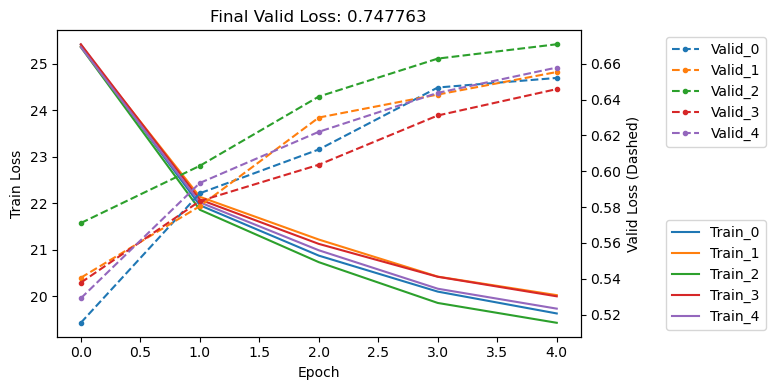

In [24]:
valid_loss = evel_fn(
    torch.tensor(oof[predict_cols].values), 
    torch.tensor(oof[target_cols].values)
    )

start_at = 0
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
ax2 = ax1.twinx()
for i, loss in enumerate(loss_history):
    ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
    ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
    
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Train Loss")
ax2.set_ylabel("Valid Loss (Dashed)")
ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
ax1.set_title(f"Final Valid Loss: {valid_loss:.6f}" )

fig.tight_layout()
plt.show()

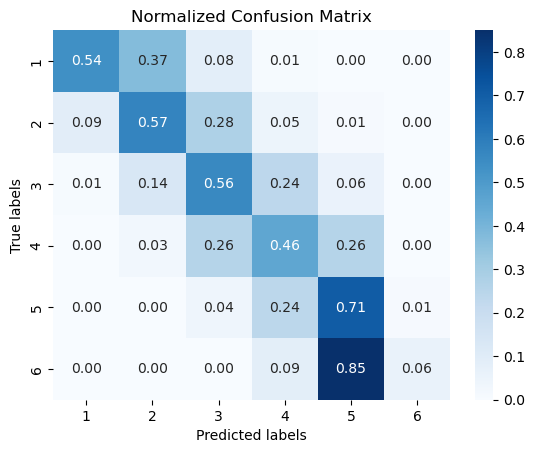

In [25]:
oof['true_score'] = oof[target_cols].apply(lambda x: np.argmax(x), axis=1)
oof['pred_score'] = oof[predict_cols].apply(lambda x: np.argmax(softmax(x)), axis=1)

cm = confusion_matrix(oof['true_score'].values, oof['pred_score'].values, normalize='true')
# Plotting the normalized confusion matrix
fig = plt.figure()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()

Overall Quadratic Weighted Kappa: 0.748384


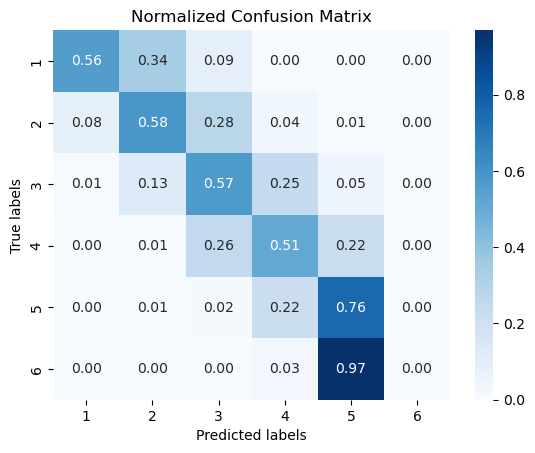

In [35]:
df_1 = oof.groupby('essay_id')[predict_cols+target_cols].mean() 

df_1['true_score'] = df_1[target_cols].apply(lambda x: np.argmax(x), axis=1)
df_1['pred_score'] = df_1[predict_cols].apply(lambda x: np.argmax(softmax(x)), axis=1)

# kappa score
kappa_score = cohen_kappa_score(df_1['true_score'].values, df_1['pred_score'].values, weights='quadratic')
print(f"Overall Quadratic Weighted Kappa: {kappa_score:.6f}")

cm = confusion_matrix(df_1['true_score'].values, df_1['pred_score'].values, normalize='true')
# Plotting the normalized confusion matrix
fig = plt.figure()
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Normalized Confusion Matrix')
plt.show()